# BMED Autoregressive Model Validation

이 노트북은 `bmed_batch_best_model.pth`에 저장된 BMED 자기회귀 모델의 성능을 검증합니다.

## 목표
- 각 실험별로 모델 예측값과 실제값 비교
- 10개 변수(VF, VA, VB, CFLA, CALA, CBLA, CFK, CAK, CBK, I)에 대한 시각화
- 각 변수별 R² 값 독립적 계산

In [52]:
# Import modules
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

np.random.seed(87)
torch.manual_seed(87)

print("✅ 모든 모듈이 성공적으로 로드되었습니다.")

✅ 모든 모듈이 성공적으로 로드되었습니다.


In [53]:
# Model Classes (copied from BMED_Autoregressive_Model.ipynb)

class SequentialStateExtractor(nn.Module):
    """
    The module based on LSTM to extract hidden dynamics from the sequential pattern of BMED.
    """
    def __init__(self, input_nodes, hidden_nodes, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_nodes = hidden_nodes
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_nodes, hidden_nodes, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_nodes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        seq_len_cpu = seq_len.detach().cpu().long()
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f'Invalid sequence lengths detected: {invalid_lengths.tolist()}')
        
        packed_input = pack_padded_sequence(x, seq_len_cpu, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_input)
        lstm_out, output_lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1))
        normed_output = self.layer_norm(lstm_out)
        return self.dropout(normed_output)


class PhysicalChangeDecoder(nn.Module):
    """
    The module based on MLP to decode the hidden state to the physical change.
    """
    def __init__(self, hidden_nodes, output_nodes, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()
        if num_nodes is None:
            num_nodes = hidden_nodes

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(hidden_nodes, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(num_nodes, output_nodes))

    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x


class PhysicsConstraintLayer(nn.Module):
    """
    The module based on MLP to apply the physical constraints to the physical changes.
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps

    def forward(self, physical_changes, current_state):
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 12 or physical_changes.size(-1) != 7:
            raise ValueError(f"Expected 12 state features and 7 physical changes")

        # Extract current state variables
        V, E, VF, VA, VB = current_state[..., 0:1], current_state[..., 1:2], current_state[..., 2:3], current_state[..., 3:4], current_state[..., 4:5]
        CFLA, CALA, CBLA = current_state[..., 5:6], current_state[..., 6:7], current_state[..., 7:8]
        CFK, CAK, CBK, I = current_state[..., 8:9], current_state[..., 9:10], current_state[..., 10:11], current_state[..., 11:12]

        # Calculate moles
        NFLA, NALA, NBLA = CFLA * VF, CALA * VA, CBLA * VB
        NFK, NAK, NBK = CFK * VF, CAK * VA, CBK * VB

        # Extract physical changes
        dVA, dVB = physical_changes[..., 0:1], physical_changes[..., 1:2]
        dNALA, dNBLA = physical_changes[..., 2:3], physical_changes[..., 3:4]
        dNAK, dNBK = physical_changes[..., 4:5], physical_changes[..., 5:6]
        nI = physical_changes[..., 6:7]
        
        # Calculate new volumes
        nVF, nVA, nVB = VF - dVA - dVB, VA + dVA, VB + dVB

        # Apply constraints
        dNALA, dNBLA, dNAK, dNBK = torch.clamp(dNALA, min=0), torch.clamp(dNBLA, min=0), torch.clamp(dNAK, min=0), torch.clamp(dNBK, min=0)

        # Calculate new moles
        nNFLA, nNALA, nNBLA = NFLA - dNALA - dNBLA, NALA + dNALA, NBLA + dNBLA
        nNFK, nNAK, nNBK = NFK - dNAK - dNBK, NAK + dNAK, NBK + dNBK

        # Apply limits
        nVF, nVA, nVB = torch.clamp(nVF, min=self.eps), torch.clamp(nVA, min=self.eps), torch.clamp(nVB, min=self.eps)
        nNFLA, nNALA, nNBLA = torch.clamp(nNFLA, min=0), torch.clamp(nNALA, min=0), torch.clamp(nNBLA, min=0)
        nNFK, nNAK, nNBK = torch.clamp(nNFK, min=0), torch.clamp(nNAK, min=0), torch.clamp(nNBK, min=0)
        nI = torch.clamp(nI, min=0)

        # Calculate new concentrations
        nCFLA, nCALA, nCBLA = nNFLA / nVF, nNALA / nVA, nNBLA / nVB
        nCFK, nCAK, nCBK = nNFK / nVF, nNAK / nVA, nNBK / nVB

        # Assemble new state
        new_state = torch.cat([V, E, nVF, nVA, nVB, nCFLA, nCALA, nCBLA, nCFK, nCAK, nCBK, nI], dim=-1)
        return new_state


class BMEDAutoregressiveModel(nn.Module):
    """
    The autoregressive model to predict the state of BMED system.
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = SequentialStateExtractor(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_state, seq_lengths):
        hidden_states = self.state_extractor(current_state, seq_lengths)
        physical_changes = self.physical_decoder(hidden_states)
        new_state = self.physics_constraint(physical_changes, current_state)
        return new_state

print("✅ 모델 클래스가 정의되었습니다.")

✅ 모델 클래스가 정의되었습니다.


In [54]:
# 데이터 처리 함수들

def norm_data(name):
    """
    Load and normalize data from CSV file.
    """
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    
    # Normalization ranges
    range_mm = {
        'V': {'min': df['V'].min() * 0.8, 'max': df['V'].max() * 1.2},
        'E': {'min': df['E'].min() * 0.8, 'max': df['E'].max() * 1.2},
        'VF': {'min': df['VF'].min() * 0.8, 'max': df['VF'].max() * 1.2},
        'VA': {'min': df['VA'].min() * 0.8, 'max': df['VA'].max() * 1.2},
        'VB': {'min': df['VB'].min() * 0.8, 'max': df['VB'].max() * 1.2},
        'CFLA': {'min': 0, 'max': df['CFLA'].max() * 1.2},
        'CALA': {'min': 0, 'max': df['CALA'].max() * 1.2},
        'CBLA': {'min': 0, 'max': df['CBLA'].max() * 1.2},
        'CFK': {'min': 0, 'max': df['CFK'].max() * 1.2},
        'CAK': {'min': 0, 'max': df['CAK'].max() * 1.2},
        'CBK': {'min': 0, 'max': df['CBK'].max() * 1.2},
        'I': {'min': 0, 'max': df['I'].max() * 1.2},
    }
    
    ndf['exp'], ndf['t'] = df['exp'], df['t']
    
    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min']) / (range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]
    
    exp_num_list = sorted(ndf['exp'].unique())
    return ndf, exp_num_list, range_mm


def denormalize_data(normalized_data, range_mm, feature_cols):
    """
    Denormalize data back to original scale.
    """
    denormalized_data = normalized_data.copy()
    
    for i, col in enumerate(feature_cols):
        if col in range_mm:
            min_val = range_mm[col]['min']
            max_val = range_mm[col]['max']
            denormalized_data[..., i] = normalized_data[..., i] * (max_val - min_val) + min_val
    
    return denormalized_data


def seq_data_const(ndf):
    """
    Set the data sequences.
    """
    sequences = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        sequences.append(exp_data[feature_cols].values)
    
    return sequences


def free_running_prediction_single(model, initial_state, num_steps, device):
    """
    Free running prediction for a single experiment.
    예측 결과에 초기값을 맨 처음에 포함하도록 수정됨.
    """
    model.eval()
    with torch.no_grad():
        # 초기 상태를 predictions에 먼저 추가
        predictions = [initial_state.clone()]  # [12]
        current_state = initial_state.unsqueeze(0).unsqueeze(0)  # [1, 1, 12]
        
        for step in range(num_steps):
            seq_len = torch.tensor([current_state.size(1)], device=device)
            next_state = model(current_state, seq_len)
            next_step = next_state[:, -1:, :]
            predictions.append(next_step.squeeze(0).squeeze(0))  # [12]
            current_state = torch.cat([current_state, next_step], dim=1)
        
        return torch.stack(predictions)  # [num_steps+1, 12]

print("✅ 데이터 처리 함수들이 정의되었습니다.")

✅ 데이터 처리 함수들이 정의되었습니다.


In [55]:
# Load and preprocess data
print("📊 데이터 로드 및 전처리...")
ndf, exp_num_list, range_mm = norm_data('BMED_DATA_AG.csv')
raw_df = pd.read_csv('BMED_DATA_AG.csv')
sequences = seq_data_const(ndf)

print(f"✅ {len(exp_num_list)}개의 실험 데이터 로드 완료")
print(f"실험 번호: {exp_num_list[:10]}{'...' if len(exp_num_list) > 10 else ''}")

# Feature columns for analysis
feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']
target_vars = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']  # Variables to analyze (excluding V, E)

📊 데이터 로드 및 전처리...
✅ 39개의 실험 데이터 로드 완료
실험 번호: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]...


In [56]:
# 모델 파라미터 및 설정 로드
print("🤖 모델 설정...")

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

# 하이퍼파라미터 로드
try:
    with open('bmed_autoregressive_optimization_results.json', 'r') as f:
        optimization_results = json.load(f)
    best_params = optimization_results['best_params']
    print("✅ 하이퍼파라미터 로드 완료")
except FileNotFoundError:
    print("⚠️ 하이퍼파라미터 파일을 찾을 수 없습니다. 기본값 사용")
    # 기본값 (필요시 수정)
    best_params = {
        'hidden_size': 64,
        'num_layers': 2,
        'extractor_dropout': 0.2,
        'decoder_layers': 2,
        'decoder_nodes': 64,
        'decoder_dropout': 0.3
    }

# 모델 파라미터
state_extractor_params = {
    'input_nodes': 12,
    'hidden_nodes': best_params['hidden_size'],
    'num_layers': 2,
    'dropout': best_params['extractor_dropout']
}

decoder_params = {
    'hidden_nodes': best_params['hidden_size'],
    'output_nodes': 7,
    'num_layers': 2,
    'num_nodes': best_params['decoder_nodes'],
    'dropout': best_params['decoder_dropout']
}

# 모델 초기화 및 가중치 로드
model = BMEDAutoregressiveModel(state_extractor_params, decoder_params)
model = model.to(device)

# 학습된 가중치 로드 (shape mismatch 발생 시 예외 처리)
try:
    model.load_state_dict(torch.load('bmed_batch_best_model.pth', map_location=device))
    model.eval()
    print(f"✅ 모델 로드 완료 (파라미터 수: {sum(p.numel() for p in model.parameters()):,})")
except RuntimeError as e:
    print("❌ 모델 가중치 로드 중 오류 발생:")
    print(str(e))
    print("⚠️ 모델 구조와 저장된 가중치의 shape이 일치하지 않습니다. 하이퍼파라미터 또는 모델 구조를 확인하세요.")
    # 필요시: 예외 발생시키거나, 임시로 모델을 랜덤 초기화 상태로 둠
    # raise e

🤖 모델 설정...
사용 디바이스: cuda
✅ 하이퍼파라미터 로드 완료
❌ 모델 가중치 로드 중 오류 발생:
Error(s) in loading state_dict for BMEDAutoregressiveModel:
	size mismatch for physical_decoder.layers.0.weight: copying a param with shape torch.Size([256, 208]) from checkpoint, the shape in current model is torch.Size([240, 208]).
	size mismatch for physical_decoder.layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for physical_decoder.layers.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for physical_decoder.layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for physical_decoder.layers.4.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([240, 240]).
	size mismatch for physical_decoder.layers

In [57]:
# Perform predictions for all experiments
print("🔮 모델 예측 수행...")

all_predictions = {}
all_actuals = {}
all_times = {}

for i, exp_num in enumerate(exp_num_list):
    # Get experiment data
    exp_data_norm = sequences[i]  # Normalized data
    exp_data_raw = raw_df[raw_df['exp'] == exp_num].sort_values(by='t')
    
    if len(exp_data_norm) < 2:
        print(f"⚠️ 실험 {exp_num}: 데이터 포인트 부족 (스킵)")
        continue
    
    # Initial state (normalized)
    initial_state = torch.tensor(exp_data_norm[0], dtype=torch.float32, device=device)
    
    # Predict remaining steps
    num_steps = len(exp_data_norm) - 1
    if num_steps > 0:
        predictions_norm = free_running_prediction_single(model, initial_state, num_steps, device)
        
        # Denormalize predictions
        predictions_denorm = denormalize_data(predictions_norm.cpu().numpy(), range_mm, feature_cols)
        
        # Get actual values (skip first point since it's initial state)
        actuals = exp_data_raw[feature_cols].values[1:]
        times = exp_data_raw['t'].values[1:]
        
        # Store results
        all_predictions[exp_num] = predictions_denorm
        all_actuals[exp_num] = actuals
        all_times[exp_num] = times
    
    if (i + 1) % 10 == 0:
        print(f"진행상황: {i + 1}/{len(exp_num_list)} 실험 완료")

print(f"✅ 총 {len(all_predictions)}개 실험의 예측 완료")

🔮 모델 예측 수행...


진행상황: 10/39 실험 완료
진행상황: 20/39 실험 완료
진행상황: 30/39 실험 완료
✅ 총 39개 실험의 예측 완료


In [58]:
# exp0에 대한 예측 결과와 실제 실험값을 비교하여 출력

exp_num = 0  # exp0

if exp_num in all_predictions and exp_num in all_actuals:
    pred = all_predictions[exp_num]
    actual = all_actuals[exp_num]
    time = all_times[exp_num] if exp_num in all_times else np.arange(len(pred))
    
    print(f"exp{exp_num} 예측 결과 vs 실제값 (앞 10개 샘플):")
    for i in range(min(10, len(pred))):
        t_val = time[i] if i < len(time) else i
        pred_str = ", ".join([f"{v:.3f}" for v in pred[i]])
        actual_str = ", ".join([f"{v:.3f}" for v in actual[i]])
        print(f"t={t_val}: 예측값=[{pred_str}] | 실제값=[{actual_str}]")
else:
    print(f"exp{exp_num}에 대한 예측 또는 실제값이 존재하지 않습니다.")


exp0 예측 결과 vs 실제값 (앞 10개 샘플):
t=0.25: 예측값=[20.000, 0.250, 1.000, 1.000, 1.000, 0.467, 0.000, 0.000, 1.032, 0.000, 0.008, 0.000] | 실제값=[20.000, 0.250, 1.002, 0.999, 0.999, 0.466, 0.000, 0.000, 1.030, 0.000, 0.009, 0.025]
t=0.5: 예측값=[20.000, 0.250, 1.781, 1.248, 1.387, 0.000, 1.257, 0.000, 0.000, 0.081, 0.450, 0.000] | 실제값=[20.000, 0.250, 1.006, 0.997, 0.997, 0.463, 0.000, 0.000, 1.024, 0.000, 0.011, 0.050]
t=0.75: 예측값=[20.000, 0.250, 2.446, 1.257, 1.387, 0.000, 2.898, 0.000, 0.000, 0.129, 2.017, 0.000] | 실제값=[20.000, 0.250, 1.013, 0.994, 0.994, 0.460, 0.000, 0.001, 1.014, 0.000, 0.015, 0.075]
t=1.0: 예측값=[20.000, 0.250, 3.336, 1.023, 1.387, 0.000, 5.854, 0.000, 0.000, 0.197, 7.765, 0.000] | 실제값=[20.000, 0.250, 1.020, 0.990, 0.990, 0.457, 0.000, 0.001, 1.000, 0.000, 0.021, 0.100]
t=1.25: 예측값=[20.000, 0.250, 4.332, 0.690, 1.387, 0.000, 21.283, 0.000, 0.000, 0.715, 11.303, 0.000] | 실제값=[20.000, 0.250, 1.033, 0.984, 0.983, 0.451, 0.000, 0.001, 0.939, 0.000, 0.074, 0.125]
t=1.5: 예측값=[20.000, 

In [59]:
# Calculate R² values for each variable
print("📈 R² 값 계산...")

r2_scores = {}
for var_idx, var_name in enumerate(target_vars):
    all_true = []
    all_pred = []
    
    for exp_num in all_predictions.keys():
        # Get feature index in the full feature list
        feature_idx = feature_cols.index(var_name)
        
        true_vals = all_actuals[exp_num][:, feature_idx]
        pred_vals = all_predictions[exp_num][:, feature_idx]
        
        all_true.extend(true_vals)
        all_pred.extend(pred_vals)
    
    # Calculate R² for this variable
    if len(all_true) > 0:
        r2 = r2_score(all_true, all_pred)
        r2_scores[var_name] = r2
        print(f"{var_name}: R² = {r2:.4f}")

print(f"\n✅ 평균 R² = {np.mean(list(r2_scores.values())):.4f}")

📈 R² 값 계산...


ValueError: Found input variables with inconsistent numbers of samples: [926, 965]

🎨 실험별 시각화 생성...
실험 #0 처리 중... (1/39)


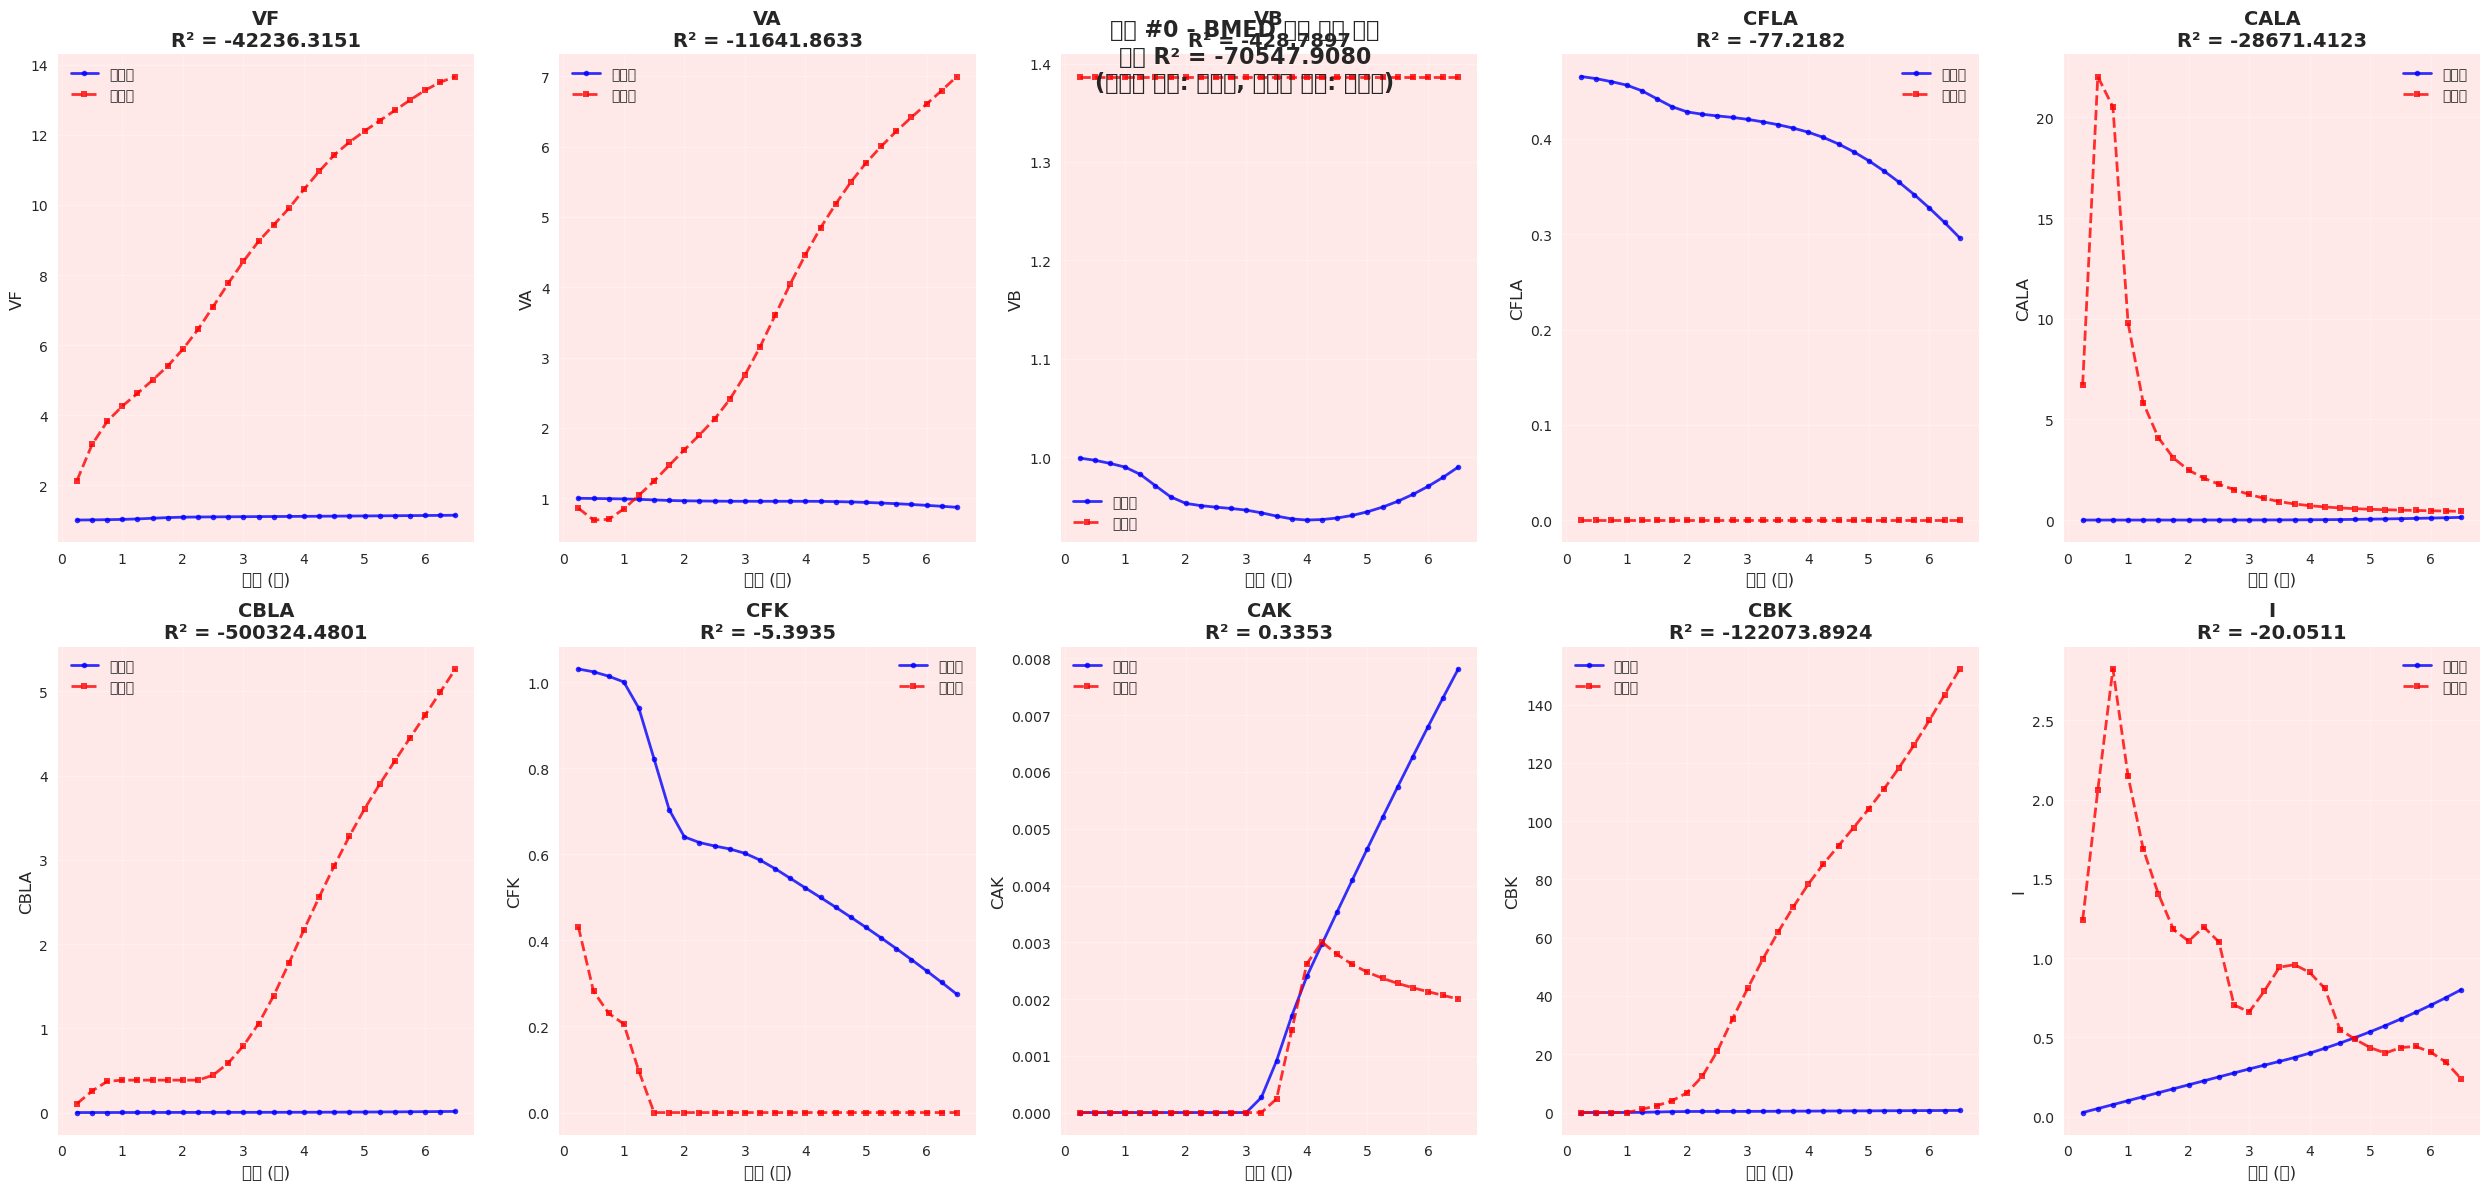

  📊 실험 #0 요약:
     평균 R² = -70547.9080
     데이터 포인트 수 = 26
     최고 성능 변수: CAK (R² = 0.3353)
     최저 성능 변수: CBLA (R² = -500324.4801)
------------------------------------------------------------
실험 #1 처리 중... (2/39)


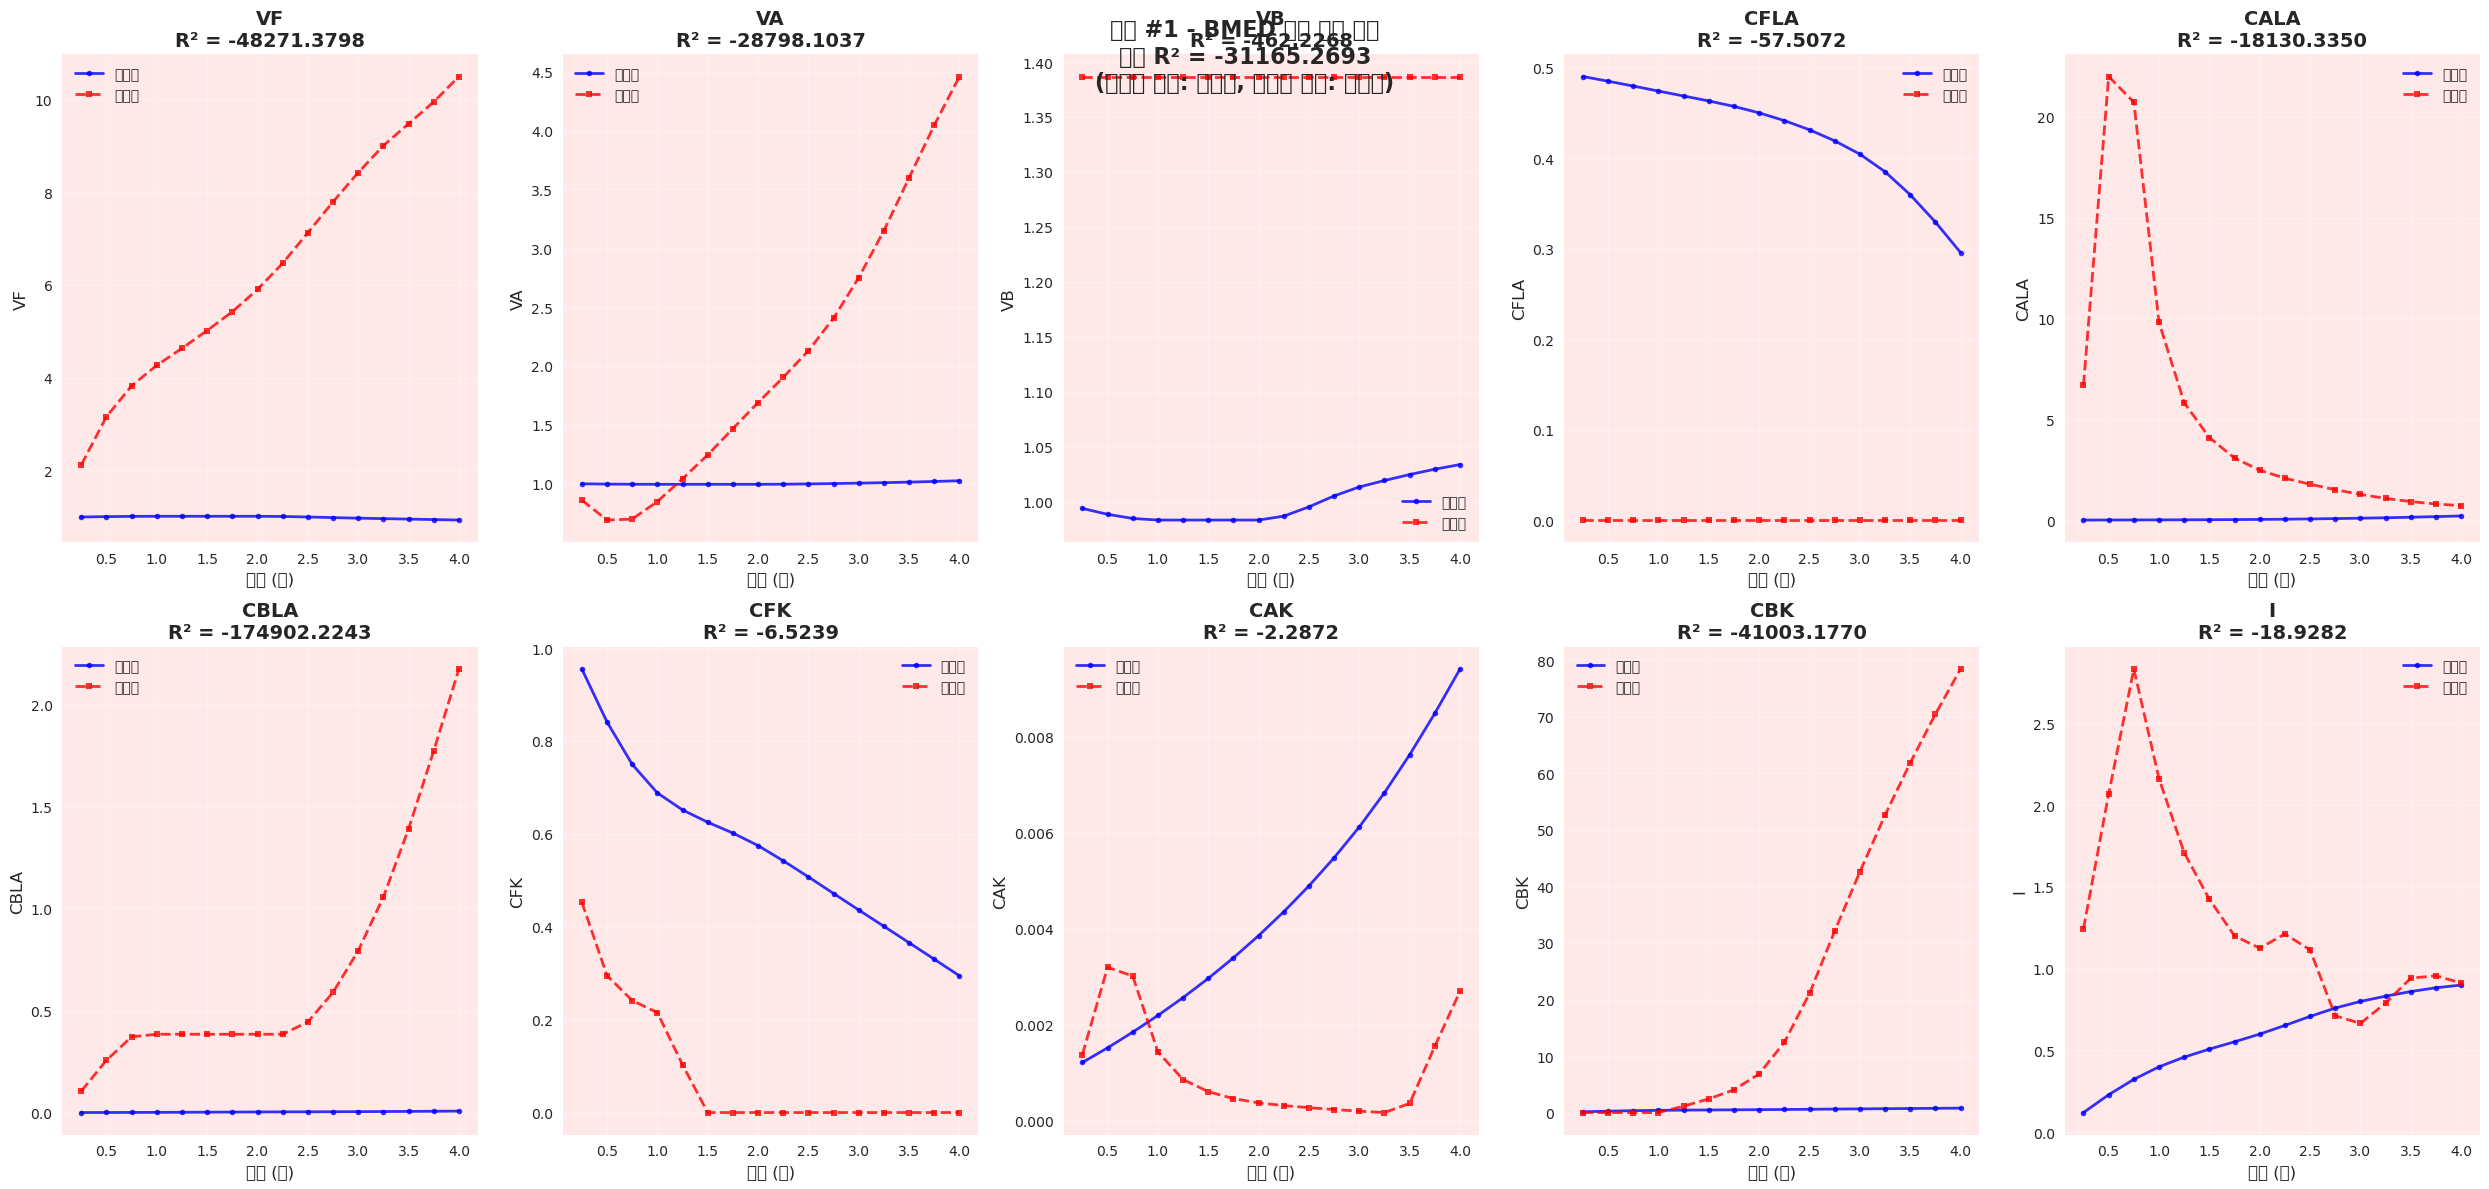

  📊 실험 #1 요약:
     평균 R² = -31165.2693
     데이터 포인트 수 = 16
     최고 성능 변수: CAK (R² = -2.2872)
     최저 성능 변수: CBLA (R² = -174902.2243)
------------------------------------------------------------
실험 #2 처리 중... (3/39)


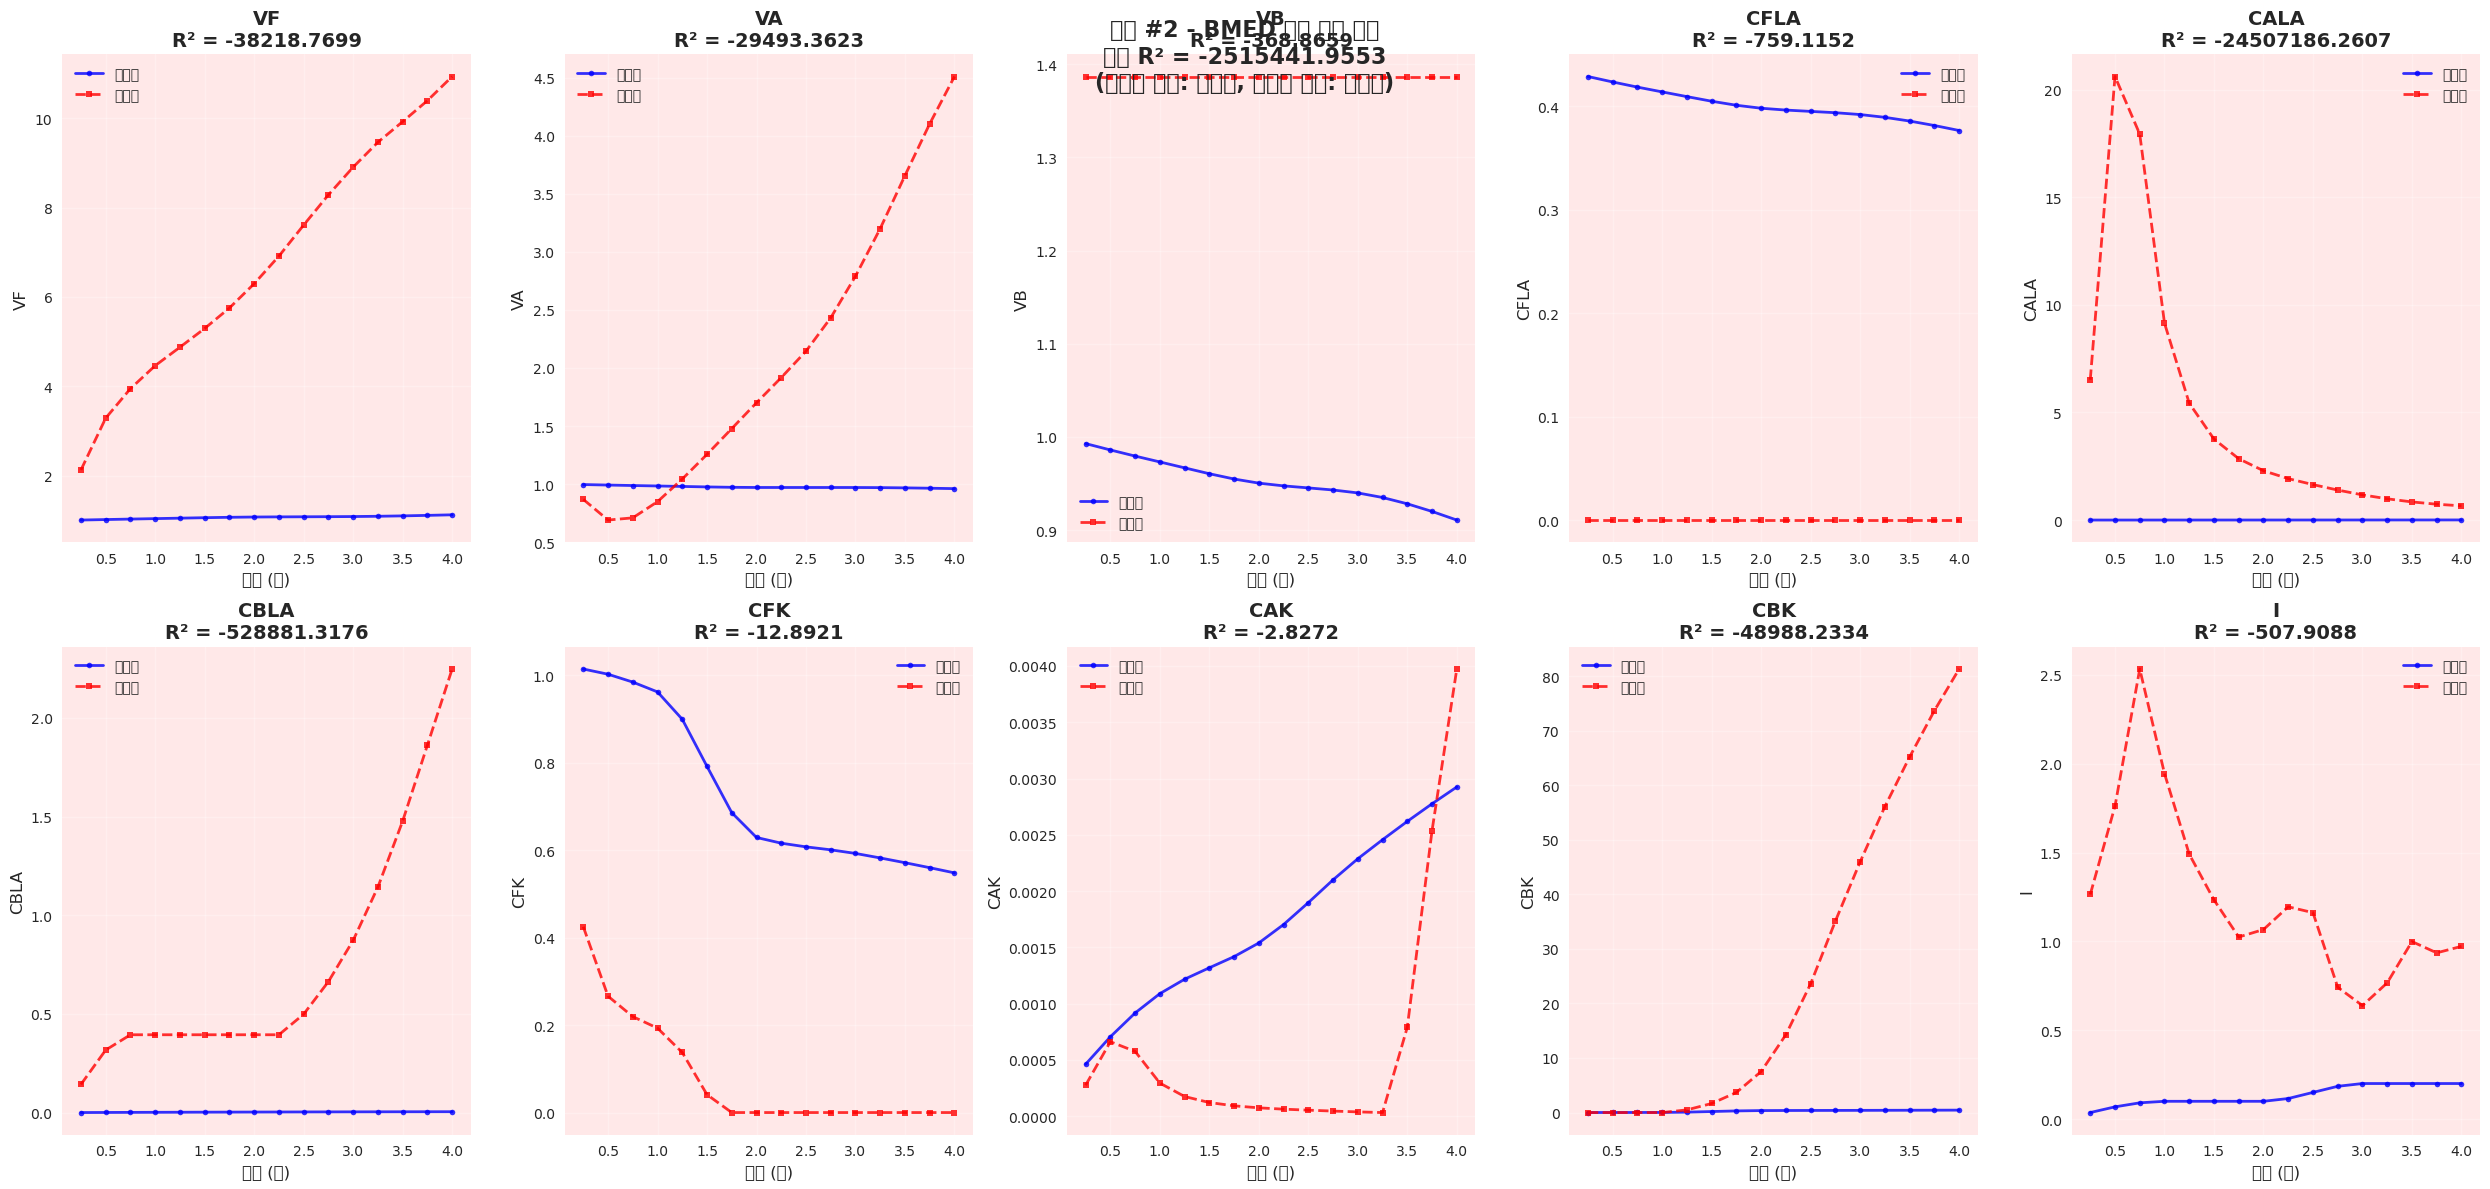

  📊 실험 #2 요약:
     평균 R² = -2515441.9553
     데이터 포인트 수 = 16
     최고 성능 변수: CAK (R² = -2.8272)
     최저 성능 변수: CALA (R² = -24507186.2607)
------------------------------------------------------------
실험 #3 처리 중... (4/39)


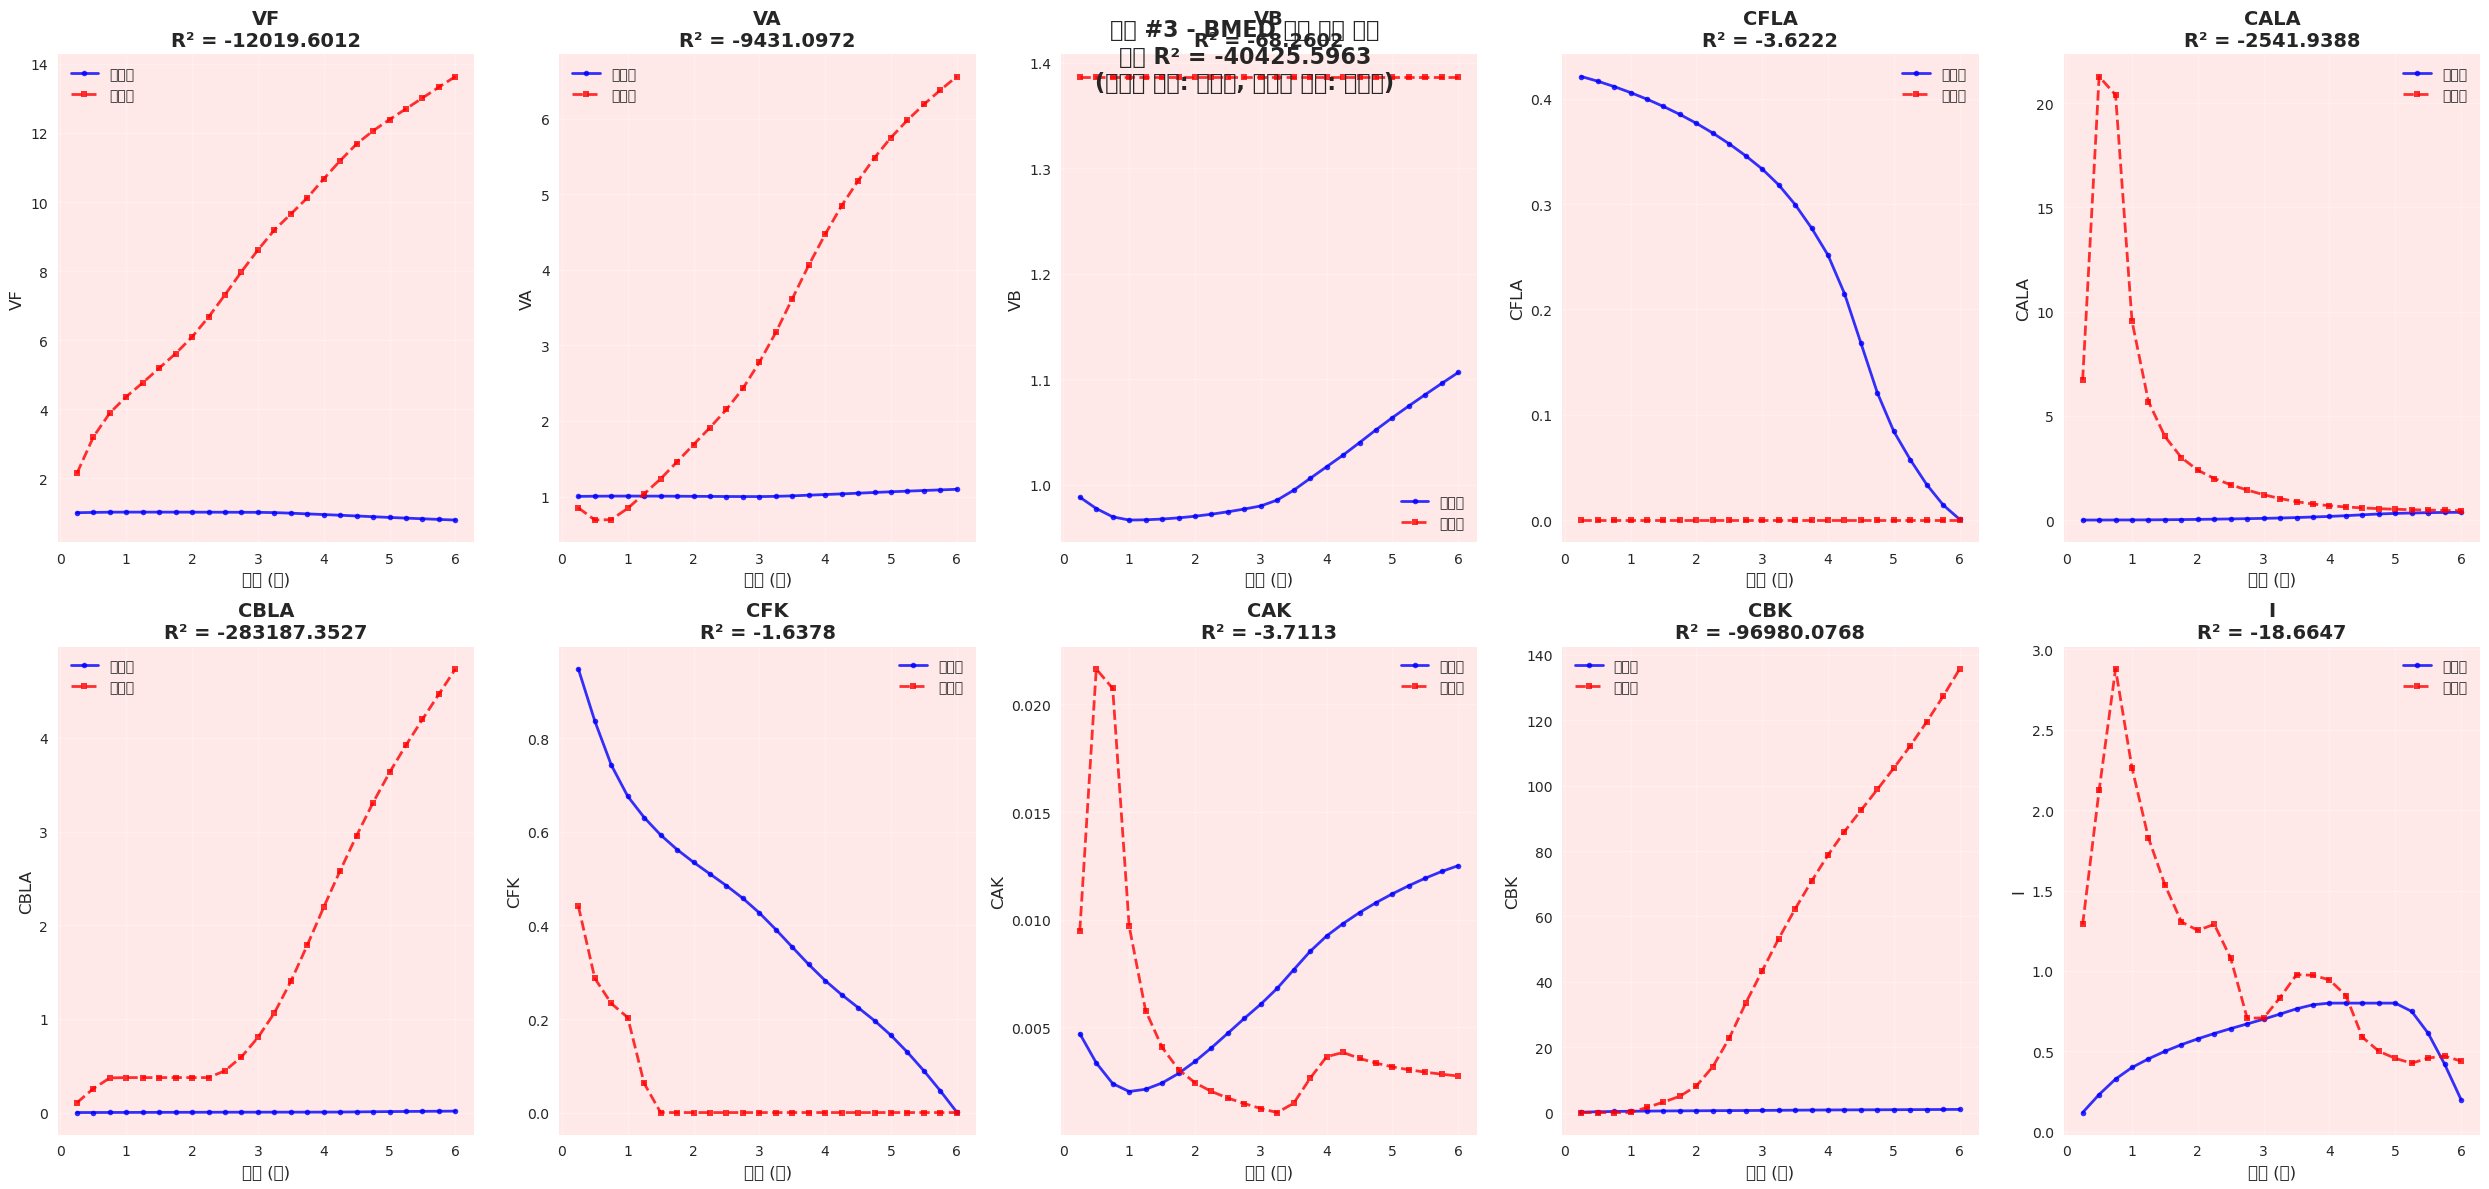

  📊 실험 #3 요약:
     평균 R² = -40425.5963
     데이터 포인트 수 = 24
     최고 성능 변수: CFK (R² = -1.6378)
     최저 성능 변수: CBLA (R² = -283187.3527)
------------------------------------------------------------
실험 #4 처리 중... (5/39)


KeyboardInterrupt: 

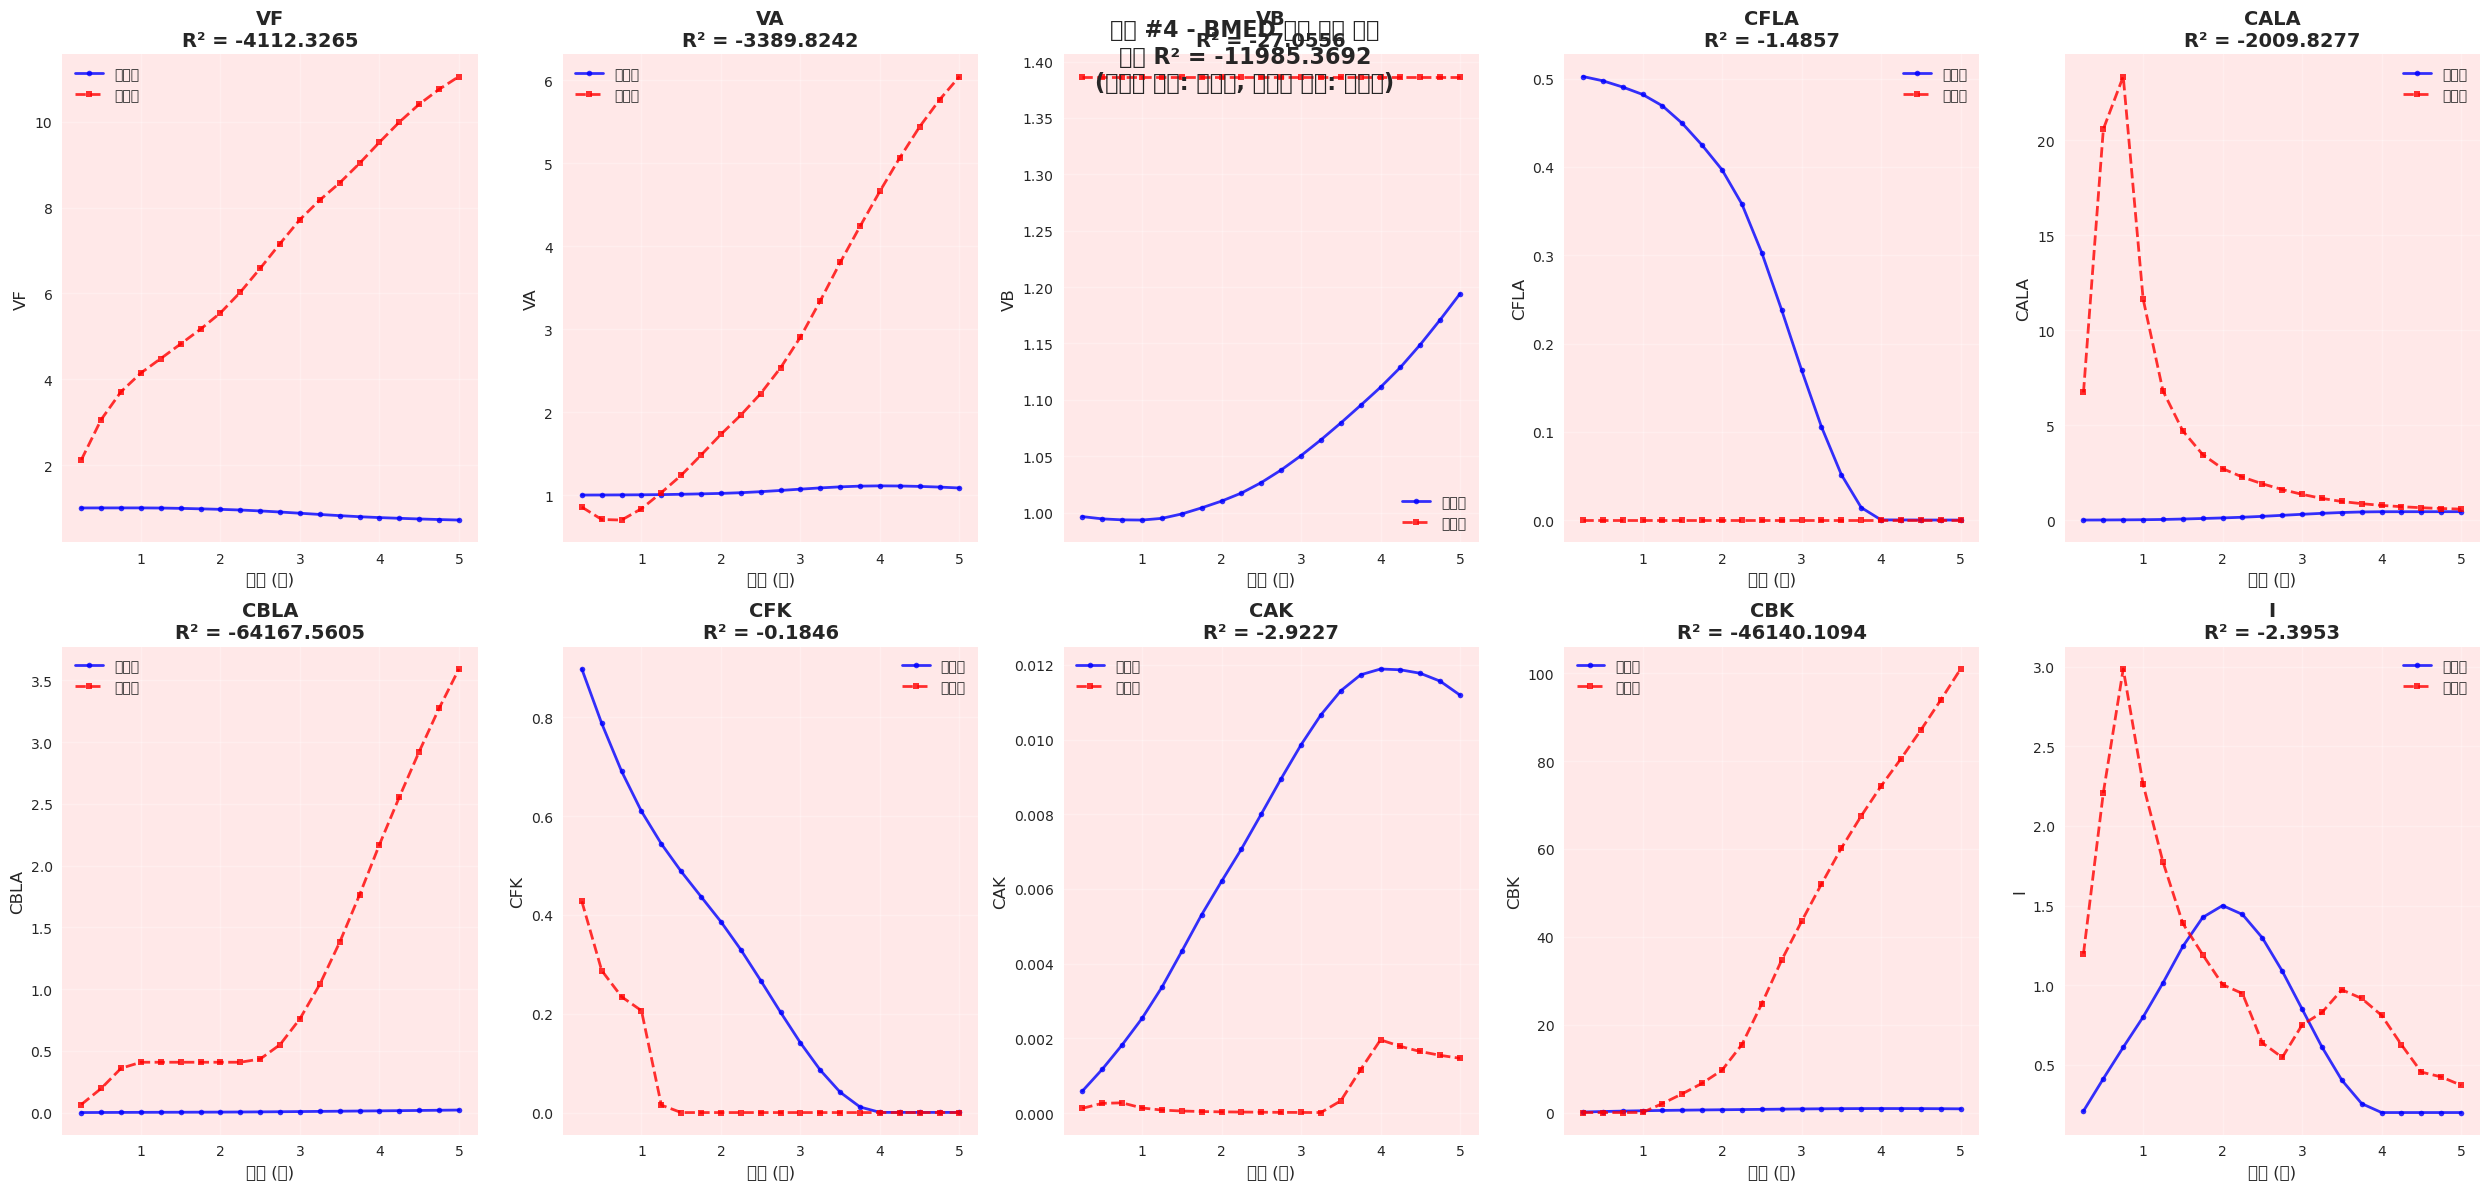

In [ ]:
# Create experiment-specific visualizations
print("🎨 실험별 시각화 생성...")

# Create directory for individual experiment plots
import os
os.makedirs('experiment_plots', exist_ok=True)

# Function to calculate R² for a single experiment
def calculate_exp_r2(exp_num, predictions, actuals):
    exp_r2_scores = {}
    for var_idx, var_name in enumerate(target_vars):
        feature_idx = feature_cols.index(var_name)
        true_vals = actuals[:, feature_idx]
        pred_vals = predictions[:, feature_idx]
        
        if len(true_vals) > 1:
            r2 = r2_score(true_vals, pred_vals)
            exp_r2_scores[var_name] = r2
        else:
            exp_r2_scores[var_name] = 0
    return exp_r2_scores

# Generate plots for each experiment
for exp_idx, exp_num in enumerate(sorted(all_predictions.keys())):
    print(f"실험 #{exp_num} 처리 중... ({exp_idx + 1}/{len(all_predictions)})")
    
    times = all_times[exp_num]
    predictions = all_predictions[exp_num]
    actuals = all_actuals[exp_num]
    
    # Calculate R² scores for this experiment
    exp_r2_scores = calculate_exp_r2(exp_num, predictions, actuals)
    avg_r2 = np.mean(list(exp_r2_scores.values()))
    
    # Setup the plot for this experiment
    fig, axes = plt.subplots(2, 5, figsize=(25, 12))
    axes = axes.flatten()
    
    for var_idx, var_name in enumerate(target_vars):
        ax = axes[var_idx]
        feature_idx = feature_cols.index(var_name)
        
        actuals_var = actuals[:, feature_idx]
        predictions_var = predictions[:, feature_idx]
        
        # Plot actual vs predicted for this experiment
        ax.plot(times, actuals_var, '-', color='blue', alpha=0.8, linewidth=2, label='실제값', marker='o', markersize=4)
        ax.plot(times, predictions_var, '--', color='red', alpha=0.8, linewidth=2, label='예측값', marker='s', markersize=4)
        
        # Formatting
        r2_val = exp_r2_scores.get(var_name, 0)
        ax.set_title(f'{var_name}\nR² = {r2_val:.4f}', fontsize=14, fontweight='bold')
        ax.set_xlabel('시간 (시)', fontsize=12)
        ax.set_ylabel(var_name, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Add R² color coding
        if r2_val >= 0.9:
            ax.patch.set_facecolor('#e8f5e8')  # Light green
        elif r2_val >= 0.8:
            ax.patch.set_facecolor('#fff2e8')  # Light orange
        elif r2_val >= 0.6:
            ax.patch.set_facecolor('#fffae8')  # Very light yellow
        else:
            ax.patch.set_facecolor('#ffe8e8')  # Light red
    
    plt.tight_layout()
    plt.suptitle(f'실험 #{exp_num} - BMED 모델 검증 결과\n평균 R² = {avg_r2:.4f}\n(파란색 실선: 실제값, 빨간색 점선: 예측값)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Save the plot
    plt.savefig(f'experiment_plots/experiment_{exp_num}_validation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print experiment summary
    print(f"  📊 실험 #{exp_num} 요약:")
    print(f"     평균 R² = {avg_r2:.4f}")
    print(f"     데이터 포인트 수 = {len(times)}")
    
    # Show top 3 and bottom 3 performing variables
    sorted_vars = sorted(exp_r2_scores.items(), key=lambda x: x[1], reverse=True)
    print(f"     최고 성능 변수: {sorted_vars[0][0]} (R² = {sorted_vars[0][1]:.4f})")
    print(f"     최저 성능 변수: {sorted_vars[-1][0]} (R² = {sorted_vars[-1][1]:.4f})")
    print("-" * 60)

print(f"\n✅ 총 {len(all_predictions)}개 실험의 개별 시각화 완료")
print("✅ 모든 그래프가 'experiment_plots/' 폴더에 저장되었습니다.")

In [ ]:
# Create R² summary table
print("📋 성능 요약표 생성...")

# Create summary DataFrame
summary_data = []
for var_name in target_vars:
    r2_val = r2_scores.get(var_name, 0)
    
    if r2_val >= 0.9:
        performance = "매우 우수"
    elif r2_val >= 0.8:
        performance = "우수"
    elif r2_val >= 0.7:
        performance = "양호"
    elif r2_val >= 0.6:
        performance = "보통"
    else:
        performance = "개선 필요"
    
    summary_data.append({
        '변수': var_name,
        'R² 값': f"{r2_val:.4f}",
        '성능 평가': performance
    })

summary_df = pd.DataFrame(summary_data)

# Display summary
print("\n" + "="*60)
print("             BMED 모델 성능 검증 결과")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)
print(f"전체 평균 R² = {np.mean(list(r2_scores.values())):.4f}")
print(f"검증된 실험 수 = {len(all_predictions)}개")
print(f"총 데이터 포인트 = {sum(len(pred) for pred in all_predictions.values())}개")
print("="*60)

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False, encoding='utf-8-sig')
print("\n✅ 성능 요약표가 'model_performance_summary.csv'에 저장되었습니다.")

📋 성능 요약표 생성...

             BMED 모델 성능 검증 결과
  변수    R² 값 성능 평가
  VF -0.4623 개선 필요
  VA  0.4289 개선 필요
  VB  0.7994    양호
CFLA  0.9109 매우 우수
CALA  0.4523 개선 필요
CBLA -0.5872 개선 필요
 CFK  0.4859 개선 필요
 CAK -0.5801 개선 필요
 CBK -0.9641 개선 필요
   I  0.8483    우수
전체 평균 R² = 0.1332
검증된 실험 수 = 39개
총 데이터 포인트 = 926개

✅ 성능 요약표가 'model_performance_summary.csv'에 저장되었습니다.


In [ ]:
# Create detailed analysis for specific experiments (optional)
print("🔍 상세 분석 (상위/하위 성능 실험)...")

# Calculate average R² for each experiment
exp_r2_scores = {}
for exp_num in all_predictions.keys():
    exp_r2_list = []
    for var_idx, var_name in enumerate(target_vars):
        feature_idx = feature_cols.index(var_name)
        true_vals = all_actuals[exp_num][:, feature_idx]
        pred_vals = all_predictions[exp_num][:, feature_idx]
        
        if len(true_vals) > 1:
            r2 = r2_score(true_vals, pred_vals)
            exp_r2_list.append(r2)
    
    if exp_r2_list:
        exp_r2_scores[exp_num] = np.mean(exp_r2_list)

# Find best and worst experiments
best_exp = max(exp_r2_scores.items(), key=lambda x: x[1])
worst_exp = min(exp_r2_scores.items(), key=lambda x: x[1])

print(f"\n최고 성능 실험: #{best_exp[0]} (평균 R² = {best_exp[1]:.4f})")
print(f"최저 성능 실험: #{worst_exp[0]} (평균 R² = {worst_exp[1]:.4f})")

print("\n🎯 모델 검증이 성공적으로 완료되었습니다!")
print("\n생성된 파일들:")
print("  - model_validation_comparison.png: 전체 비교 그래프")
print("  - model_performance_summary.csv: 성능 요약표")

🔍 상세 분석 (상위/하위 성능 실험)...

최고 성능 실험: #15 (평균 R² = -0.7796)
최저 성능 실험: #10 (평균 R² = -77.4898)

🎯 모델 검증이 성공적으로 완료되었습니다!

생성된 파일들:
  - model_validation_comparison.png: 전체 비교 그래프
  - model_performance_summary.csv: 성능 요약표


In [ ]:
# Create experiment-wise performance summary
print("📋 실험별 성능 요약 생성...")

exp_summary_data = []
exp_r2_all = {}

for exp_num in sorted(all_predictions.keys()):
    predictions = all_predictions[exp_num]
    actuals = all_actuals[exp_num]
    
    # Calculate R² scores for this experiment
    exp_r2_scores = {}
    for var_idx, var_name in enumerate(target_vars):
        feature_idx = feature_cols.index(var_name)
        true_vals = actuals[:, feature_idx]
        pred_vals = predictions[:, feature_idx]
        
        if len(true_vals) > 1:
            r2 = r2_score(true_vals, pred_vals)
            exp_r2_scores[var_name] = r2
        else:
            exp_r2_scores[var_name] = 0
    
    avg_r2 = np.mean(list(exp_r2_scores.values()))
    exp_r2_all[exp_num] = avg_r2
    
    # Find best and worst variables for this experiment
    sorted_vars = sorted(exp_r2_scores.items(), key=lambda x: x[1], reverse=True)
    best_var = sorted_vars[0]
    worst_var = sorted_vars[-1]
    
    exp_summary_data.append({
        '실험번호': exp_num,
        '평균_R²': f"{avg_r2:.4f}",
        '최고성능변수': f"{best_var[0]} ({best_var[1]:.3f})",
        '최저성능변수': f"{worst_var[0]} ({worst_var[1]:.3f})",
        '데이터포인트수': len(all_times[exp_num])
    })

# Create DataFrame and display
exp_summary_df = pd.DataFrame(exp_summary_data)

print("\n" + "="*80)
print("                    실험별 성능 요약")
print("="*80)
print(exp_summary_df.to_string(index=False))
print("="*80)

# Find top 5 and bottom 5 experiments
sorted_exps = sorted(exp_r2_all.items(), key=lambda x: x[1], reverse=True)

print(f"\n🏆 상위 5개 실험:")
for i, (exp_num, avg_r2) in enumerate(sorted_exps[:5]):
    print(f"  {i+1}. 실험 #{exp_num}: 평균 R² = {avg_r2:.4f}")

print(f"\n⚠️ 하위 5개 실험:")
for i, (exp_num, avg_r2) in enumerate(sorted_exps[-5:]):
    rank = len(sorted_exps) - 4 + i
    print(f"  {rank}. 실험 #{exp_num}: 평균 R² = {avg_r2:.4f}")

# Save experiment summary
exp_summary_df.to_csv('experiment_performance_summary.csv', index=False, encoding='utf-8-sig')
print(f"\n✅ 실험별 성능 요약이 'experiment_performance_summary.csv'에 저장되었습니다.")
print("="*80)

📋 실험별 성능 요약 생성...

                    실험별 성능 요약
 실험번호    평균_R²        최고성능변수        최저성능변수  데이터포인트수
    1 -43.8944    VF (0.940) VB (-430.342)       26
    2 -50.5514     I (0.780) VB (-465.208)       16
    3 -43.8146  CFK (-0.294) VB (-369.882)       16
    4  -8.9025     I (0.490)  VB (-68.490)       24
    5  -5.0651    VA (0.727)  VB (-27.395)       20
    6  -3.3713     I (0.390)  VB (-18.258)       20
    7  -3.6956    VA (0.826)  VB (-24.508)       24
    8  -3.5538     I (0.834)  VB (-22.482)       20
    9  -3.3893    VA (0.822)  VB (-12.838)       16
   10 -77.4898     I (0.927) VB (-742.776)       16
   11 -10.3187     I (0.971)  VB (-81.722)       20
   12 -15.0190  CFLA (0.579) VB (-131.383)       28
   13 -53.4683 CFLA (-0.519) VB (-261.997)       28
   14 -13.2405     I (0.985) VB (-121.215)       28
   15  -0.7796     I (0.601)  CAK (-2.212)       24
   16  -1.7802   CFK (0.931)    I (-5.161)       16
   17 -11.9167     I (0.990) VB (-100.508)       20
   18 -18.2916 